In [1]:
import sys
import os
import subprocess
    
import math
import re
# import collections
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
# from tqdm import tqdm
import traceback
import hashlib
import datetime

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import postgresql_v3_event_storage
from tool.misc.event_analysis_record_v3_6_update import EventAnalysisRecordV3_6_update
import dataset_query_functions_v3

#import ROOT

# import tool.npy_frames_visualization as npy_vis
import tool.acqconv
from data_analysis_utils import *
from event_recognition_efficiency_v3 import *
# import supervised_classification as supc    


Welcome to JupyROOT 6.13/02


In [3]:
#events_data_table_name = '_old5_spb_processing_v3_flatmap.event' # unnecessary, does not apply for other tables
# events_data_table_name = '_old3_spb_processing_v3.event'

In [4]:
data_snippets_dir = 'ver3_flatmap_data_snippets'
os.makedirs(data_snippets_dir, exist_ok=True)

# Selecting data

In [5]:
event_processing_cls = event_processing_v3.EventProcessingV3
event_processing_cls.event_analysis_record_class = EventAnalysisRecordV3_6_update
event_v3_storage_provider = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap_old5.ini'), 
    table_names_version='ver3',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider)

In [6]:
columns_for_analysis_dict = query_functions.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=(
        '^.+$',
    ),
    
    default_excluded_columns_re_list=[],
#     for debugging selection
    included_columns_re_list=[('^$','^source_file_acquisition_full$'), ('^$','^source_file_acquisition$'), ('^$','^global_gtu$'), ('^$','^packet_id$'), 
                              ('^$','gtu_in_packet'), ('^$','event_id'), ('^$','num_gtu'), 
                              '^bg_.*', 
                              ('gtu_datetime','min'), 
                              ('gps_lat','mean'), ('gps_lon','mean'), ('gps_alt','mean')
                             ]
)

In [7]:
removed_cols = {'spb_processing_v3.event_bg_x_y':['median','median_gz','size']}
for table,cols_list in columns_for_analysis_dict.items():
    if table not in removed_cols:
        continue
    for removed_col in removed_cols[table]:
        try:
            del cols_list[ cols_list.index(removed_col) ]
        except ValueError:
            pass
    
columns_for_analysis_dict

{'_old5_spb_processing_v3_flatmap.event': ['event_id',
  'source_file_acquisition_full',
  'source_file_acquisition',
  'global_gtu',
  'packet_id',
  'gtu_in_packet',
  'num_gtu'],
 '_old5_spb_processing_v3_flatmap.event_bg': ['event_id',
  'count_nonzero',
  'sum',
  'norm_sum',
  'min',
  'max',
  'mean',
  'std',
  'mean_gz',
  'std_gz',
  'size',
  'median',
  'median_gz'],
 '_old5_spb_processing_v3_flatmap.event_bg_gtu_x': ['event_id',
  'count_nonzero',
  'sum',
  'norm_sum',
  'min',
  'max',
  'mean',
  'std',
  'mean_gz',
  'std_gz',
  'size',
  'median',
  'median_gz',
  'width',
  'height',
  'area'],
 '_old5_spb_processing_v3_flatmap.event_bg_gtu_x_clusters': ['event_id',
  'count',
  'sizes_min',
  'sizes_max',
  'sizes_mean',
  'sizes_std',
  'sums_sum',
  'sums_min',
  'sums_max',
  'sums_mean',
  'sums_std',
  'clu_widths_max',
  'clu_heights_max',
  'clu_widths_min',
  'clu_widths_mean',
  'clu_heights_mean',
  'clu_widths_std',
  'clu_heights_std',
  'clu_areas_min',

In [8]:
#import pprint
split_columns_for_analysis_dict = query_functions.split_to_smaller_dicts(columns_for_analysis_dict,300)
#print(select_clause_str)
for i,g in enumerate(split_columns_for_analysis_dict):
    tot_items = 0
    for k,vl in g.items():
        tot_items += len(vl)
    print(i,tot_items)
    
    for t, vl in g.items():
        sys.stdout.write(t)
        sys.stdout.write('\n\t- ')
        print('\n\t- '.join(vl))
        print()
    
    print('-'*60)

0 234
_old5_spb_processing_v3_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_acquisition
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

_old5_spb_processing_v3_flatmap.event_gps_lat
	- mean

_old5_spb_processing_v3_flatmap.event_gps_lon
	- mean

_old5_spb_processing_v3_flatmap.event_gps_alt
	- mean

_old5_spb_processing_v3_flatmap.event_gtu_datetime
	- min

_old5_spb_processing_v3_flatmap.event_bg_x_y
	- event_id
	- count_nonzero
	- sum
	- norm_sum
	- min
	- max
	- mean
	- std
	- mean_gz
	- std_gz
	- size
	- median
	- median_gz
	- width
	- height
	- area

_old5_spb_processing_v3_flatmap.event_bg_x_y_clusters
	- event_id
	- count
	- sizes_min
	- sizes_max
	- sizes_mean
	- sizes_std
	- sums_sum
	- sums_min
	- sums_max
	- sums_mean
	- sums_std
	- clu_widths_max
	- clu_heights_max
	- clu_widths_min
	- clu_widths_mean
	- clu_heights_mean
	- clu_widths_std
	- clu_heights_std
	- clu_areas_min
	- clu_areas_max
	- clu_areas_mean
	- clu_areas_std
	- max_area_cl

In [9]:
current_columns_for_analysis_dict = split_columns_for_analysis_dict[0]

select_clause_str, joined_tables_list = \
    query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
join_clauses_str = \
    query_functions.get_query_clauses__join(joined_tables_list)
where_clauses_str = " AND config_info_id=1 AND source_file_acquisition NOT LIKE '%-sqz.root' AND source_file_acquisition NOT LIKE '%-sqz-dis.root'"
    
events_selection_query = query_functions.get_events_selection_query_plain(
    source_data_type_num=1,
    select_additional=select_clause_str, join_additional=join_clauses_str,
    where_additional=where_clauses_str,
    order_by='{data_table_name}.event_id', limit=350000, offset=0,
    base_select='',
#    data_table_name_overwrite=events_data_table_name
)

print(events_selection_query)


    SELECT 
        
        _old5_spb_processing_v3_flatmap.event.event_id, _old5_spb_processing_v3_flatmap.event.source_file_acquisition_full, _old5_spb_processing_v3_flatmap.event.source_file_acquisition, _old5_spb_processing_v3_flatmap.event.global_gtu, _old5_spb_processing_v3_flatmap.event.packet_id, _old5_spb_processing_v3_flatmap.event.gtu_in_packet, _old5_spb_processing_v3_flatmap.event.num_gtu, _old5_spb_processing_v3_flatmap.event_gps_lat.mean AS gps_lat_mean, _old5_spb_processing_v3_flatmap.event_gps_lon.mean AS gps_lon_mean, _old5_spb_processing_v3_flatmap.event_gps_alt.mean AS gps_alt_mean, _old5_spb_processing_v3_flatmap.event_gtu_datetime.min AS gtu_datetime_min, _old5_spb_processing_v3_flatmap.event_bg_x_y.event_id AS bg_x_y_event_id, _old5_spb_processing_v3_flatmap.event_bg_x_y.count_nonzero AS bg_x_y_count_nonzero, _old5_spb_processing_v3_flatmap.event_bg_x_y.sum AS bg_x_y_sum, _old5_spb_processing_v3_flatmap.event_bg_x_y.norm_sum AS bg_x_y_norm_sum, _old5_spb_proces

In [10]:
flight_data_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

In [11]:
prev_colwidth = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
flight_data_df[flight_data_df.source_file_acquisition_full.str.endswith(".root")]

,event_id,source_file_acquisition_full,source_file_acquisition,global_gtu,packet_id,gtu_in_packet,num_gtu,gps_lat_mean,gps_lon_mean,gps_alt_mean,...,bg_norm_sum,bg_min,bg_max,bg_mean,bg_std,bg_mean_gz,bg_std_gz,bg_size,bg_median,bg_median_gz
0,1,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,169,1,41,9,-43.8621,172.355,33239.2,...,1793.970,0,12,0.269536,0.772524,1.84672,1.084580,36.0,0.00000,1.43213
1,2,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,222,1,94,9,-43.8621,172.355,33239.2,...,1793.970,0,12,0.269536,0.772524,1.84672,1.084580,36.0,0.00000,1.43213
2,3,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,238,1,110,14,-43.8621,172.355,33239.2,...,1793.970,0,12,0.269536,0.772524,1.84672,1.084580,36.0,0.00000,1.43213
3,4,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,424,3,40,17,-43.8621,172.355,33239.2,...,2258.020,0,9,0.257944,0.725360,1.78128,0.959121,36.0,0.00000,1.41060
4,5,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,445,3,61,10,-43.8621,172.355,33239.2,...,2258.020,0,9,0.257944,0.725360,1.78128,0.959121,36.0,0.00000,1.41060
5,6,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,662,5,22,9,-43.8621,172.355,33239.1,...,908.436,0,15,0.274886,0.791092,1.87681,1.125340,22.0,0.00000,1.50596
6,7,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,681,5,41,9,-43.8621,172.355,33239.1,...,908.436,0,15,0.274886,0.791092,1.87681,1.125340,22.0,0.00000,1.50596
7,8,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,721,5,81,9,-43.8621,172.355,33239.1,...,908.436,0,15,0.274886,0.791092,1.87681,1.125340,22.0,0.00000,1.50596
8,9,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,807,6,39,10,-43.8620,172.355,33238.8,...,1641.510,0,13,0.265601,0.770788,1.83721,1.105530,36.0,0.00000,1.42462
9,10,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170425/allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root,936,7,40,17,-43.8620,172.355,33238.6,...,2248.310,0,9,0.259015,0.731674,1.79991,0.972973,36.0,0.00000,1.42462


In [12]:
pd.set_option('display.max_colwidth', prev_colwidth)

# Distributions

In [13]:
len(flight_data_df[flight_data_df.bg_size >= 36])/len(flight_data_df) # [flight_data_df.bg_size >= 36]

0.6163942616110408

In [14]:
## gtu_datetime

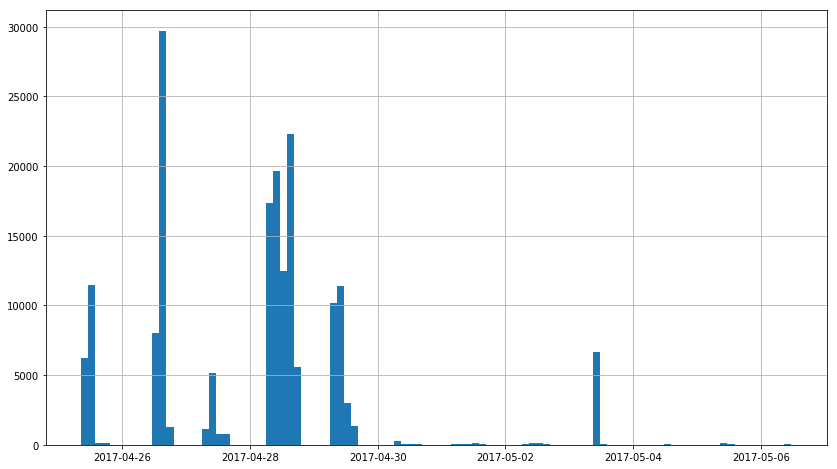

In [15]:
flight_data_df.gtu_datetime_min.hist(bins=100,figsize=(14,8),)
plt.show()

In [16]:
flight_data_df.gtu_datetime_min.min()

Timestamp('2017-04-25 08:31:48.450785')

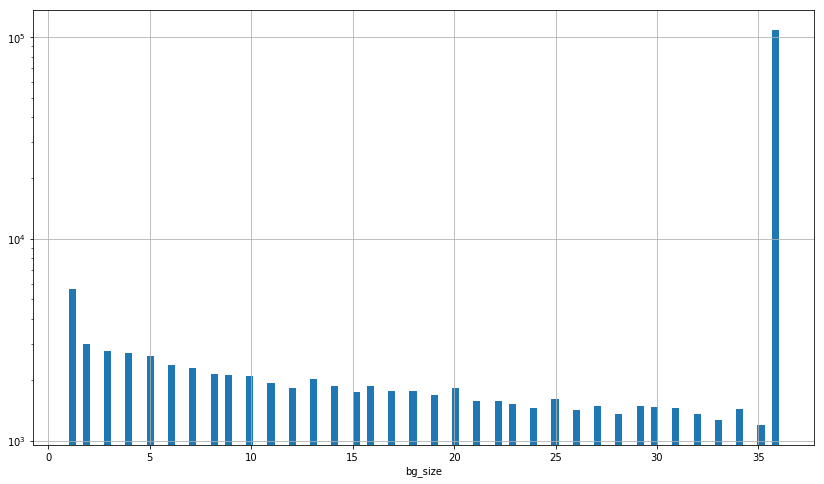

In [17]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_size.hist(bins=100,figsize=(14,8))
h.set_yscale('log')
h.set_xlabel('bg_size')
plt.show()

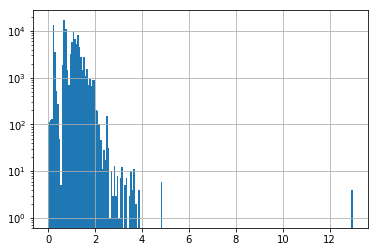

0.9819895000000001
0.9383441642453212
108576


In [18]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[(flight_data_df.bg_size >= 36)]
h = filtered_df.bg_mean.hist(bins=200)
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))
print(len(filtered_df))

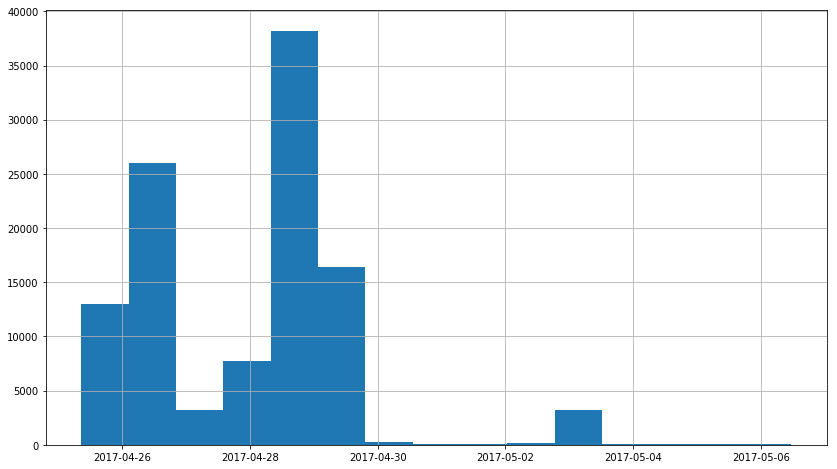

In [19]:
filtered_df.gtu_datetime_min.hist(bins=15,figsize=(14,8))
plt.show()

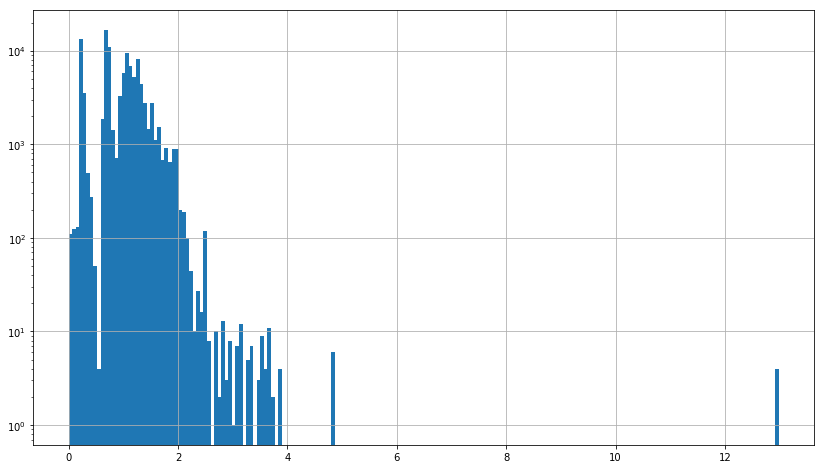

0.980335
0.9367119204864962
107339


In [20]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[(flight_data_df.bg_size >= 36) & (flight_data_df.gtu_in_packet >= 38)]
h = filtered_df.bg_mean.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))
print(len(filtered_df))

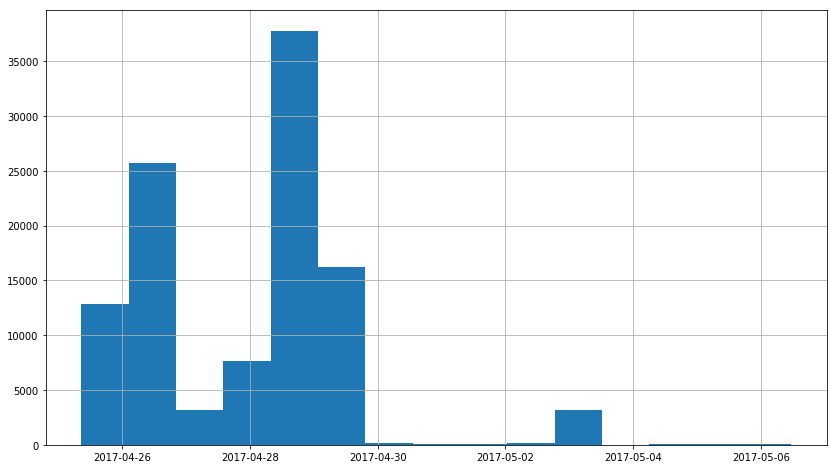

In [21]:
filtered_df.gtu_datetime_min.hist(bins=15,figsize=(14,8))
plt.show()

In [22]:
filtered_df.gtu_datetime_min.min()

Timestamp('2017-04-25 08:31:48.450785')

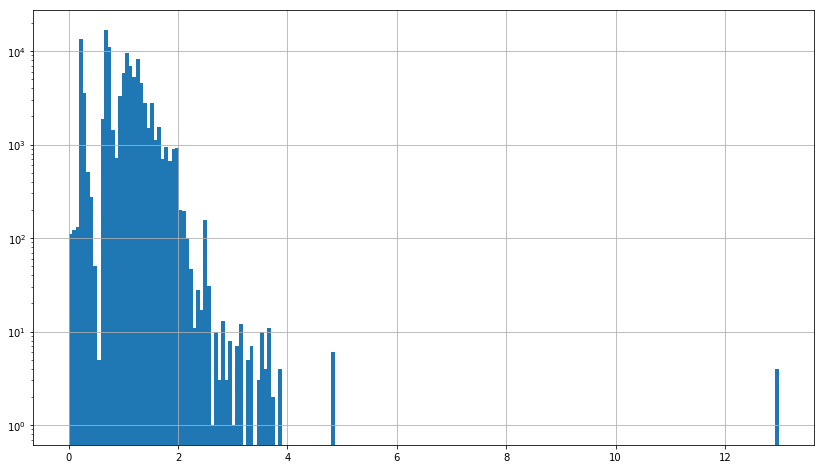

0.9819895000000001
0.9383441642453212
108576


In [23]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[(flight_data_df.bg_size >= 36) ]
h = filtered_df.bg_mean.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))
print(len(filtered_df))

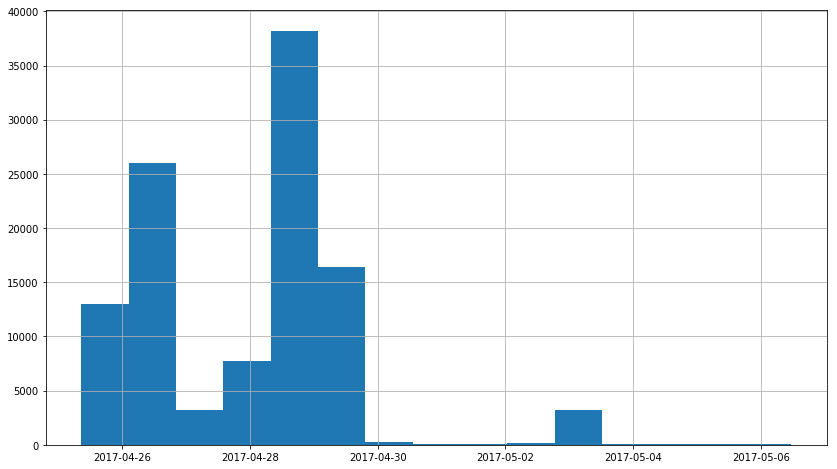

In [24]:
filtered_df.gtu_datetime_min.hist(bins=15,figsize=(14,8))
plt.show()

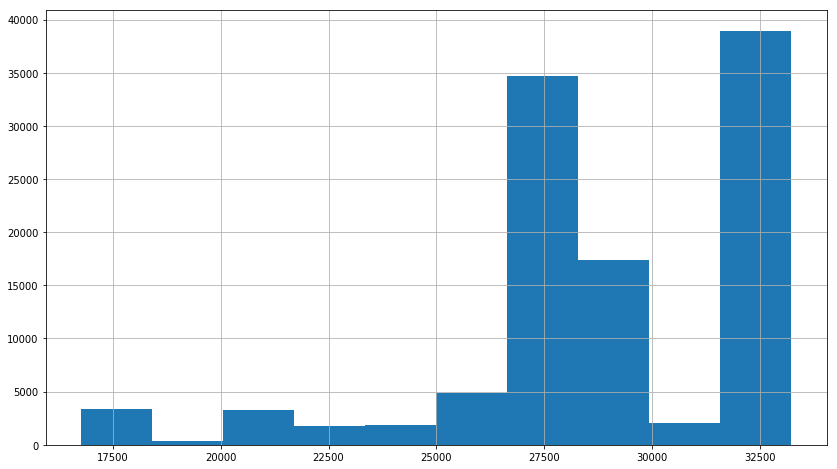

In [25]:
filtered_df.gps_alt_mean.hist(bins=10,figsize=(14,8))
plt.show()

## Final filtration

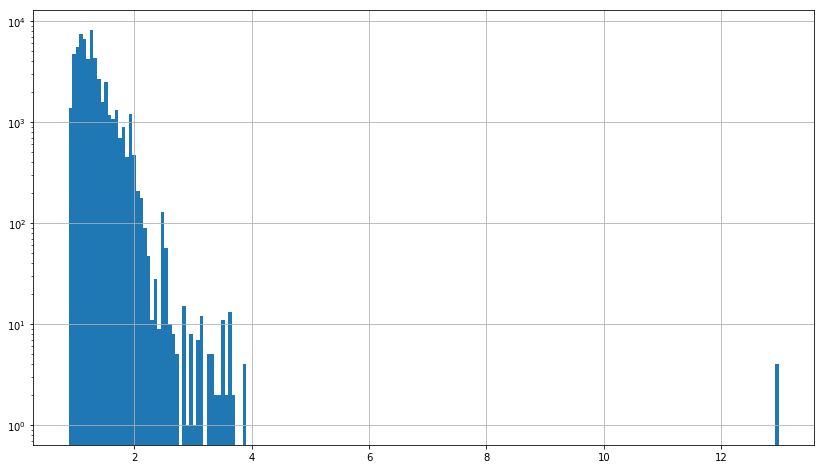

1.21771
1.2750416846875274
176147 57045


In [26]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_background_df = flight_data_df[(flight_data_df.bg_size >= 36) & (flight_data_df.bg_x_y_count_nonzero > 8*8*4*7)]
h = filtered_background_df.bg_mean.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
plt.show()
print(np.median(filtered_background_df.bg_mean))
print(np.mean(filtered_background_df.bg_mean))
print(len(flight_data_df),len(filtered_background_df))


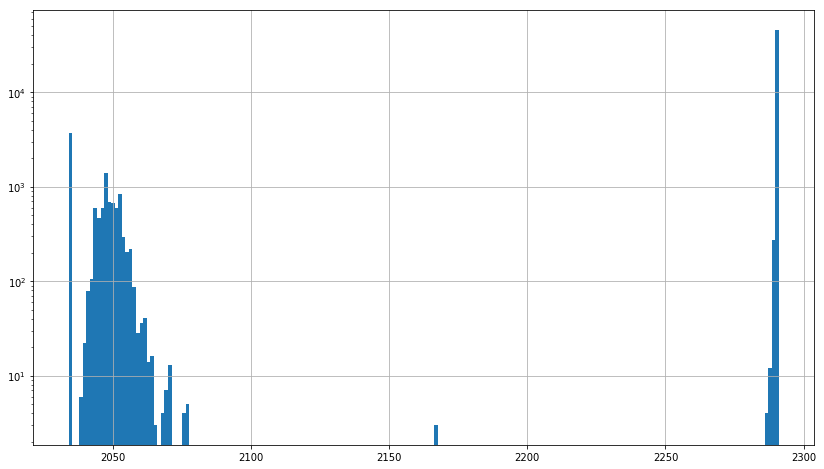

2290.0
2243.772407748269


In [27]:
h = filtered_background_df.bg_x_y_count_nonzero.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
plt.show()
print(np.median(filtered_background_df.bg_x_y_count_nonzero))
print(np.mean(filtered_background_df.bg_x_y_count_nonzero))


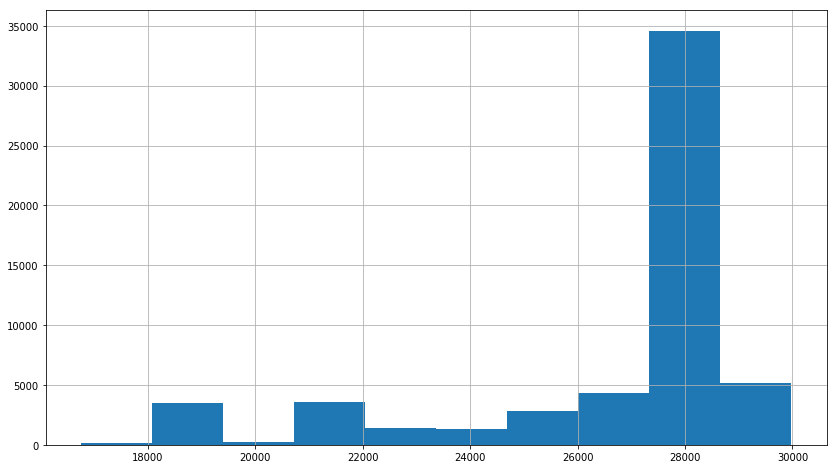

In [28]:
filtered_background_df.gps_alt_mean.hist(bins=10,figsize=(14,8))
plt.show()

In [29]:
filtered_background_df.gtu_datetime_min.min()

Timestamp('2017-04-27 08:25:12.981838')

## Altitude - background relation

0    0.00  0.10  0      nan        nan       
1    0.10  0.20  0      nan        nan       
2    0.20  0.30  0      nan        nan       
3    0.30  0.40  0      nan        nan       
4    0.40  0.50  0      nan        nan       
5    0.50  0.60  0      nan        nan       
6    0.60  0.70  0      nan        nan       
7    0.70  0.80  0      nan        nan       
8    0.80  0.90  346    27634.600  28016.100 


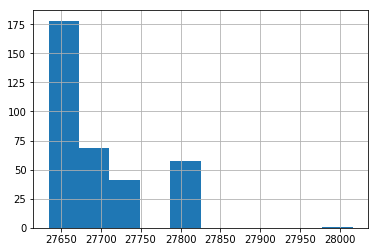

9    0.90  1.00  6056   21239.500  29824.000 


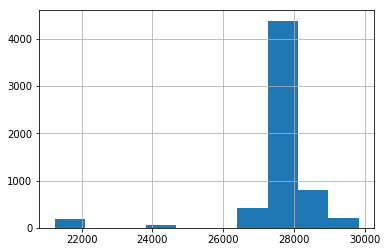

10   1.00  1.10  10885  21238.700  29823.900 


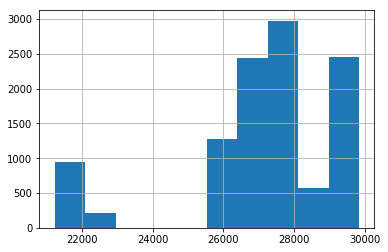

11   1.10  1.20  9776   19741.700  29695.800 


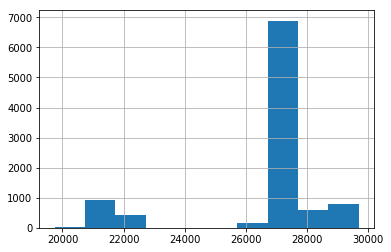

12   1.20  1.30  10881  16905.900  29964.000 


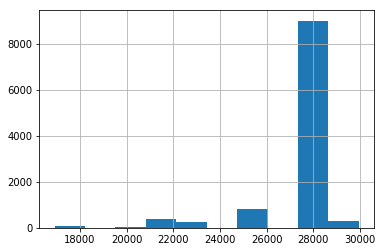

13   1.30  1.40  5981   16762.300  29979.600 


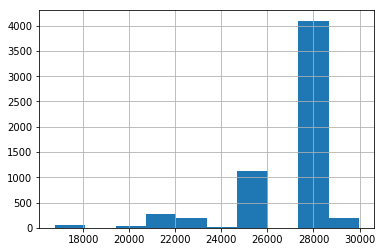

14   1.40  1.50  2813   18620.000  28478.100 


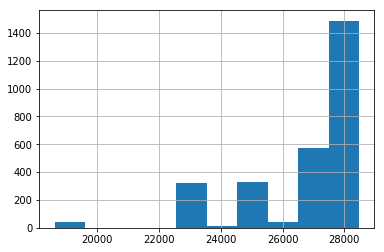

15   1.50  1.60  3273   16837.600  27809.900 


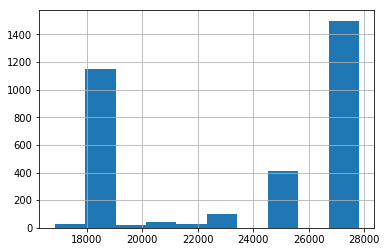

16   1.60  1.70  2158   17821.300  27944.000 


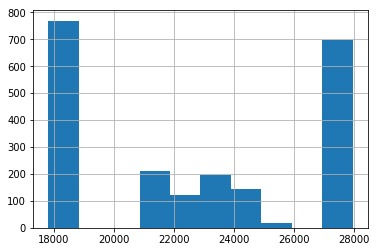

17   1.70  1.80  1228   18293.300  27946.600 


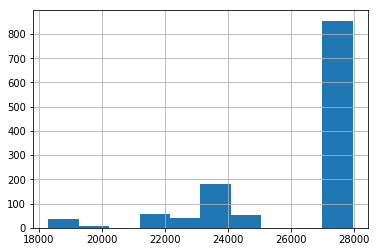

18   1.80  1.90  1080   17936.100  27911.900 


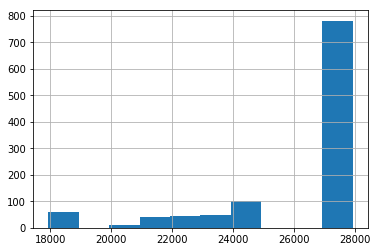

19   1.90  2.00  1664   18278.800  27858.900 


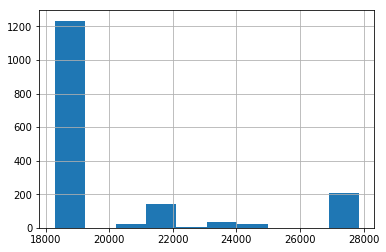

20   2.00  2.10  279    18279.500  27827.900 


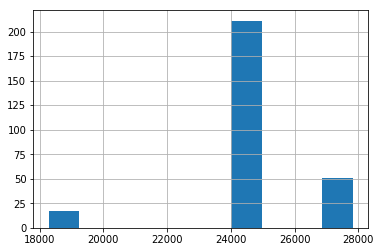

21   2.10  2.20  211    18280.300  27488.900 


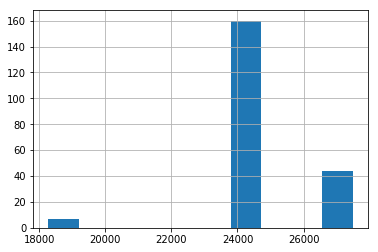

22   2.20  2.30  68     18279.500  27489.200 


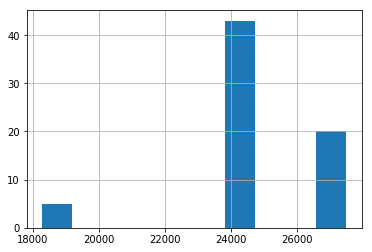

23   2.30  2.40  38     27488.600  27489.100 


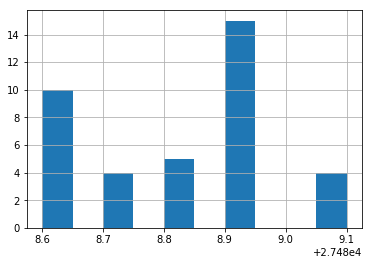

24   2.40  2.50  112    19046.400  27488.300 


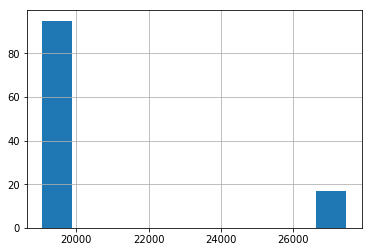

25   2.50  2.60  92     19047.400  27487.000 


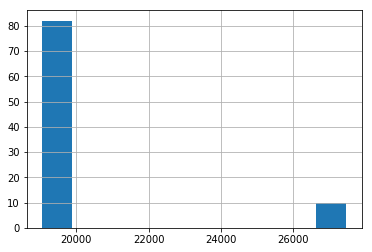

26   2.60  2.70  8      27485.500  27485.700 


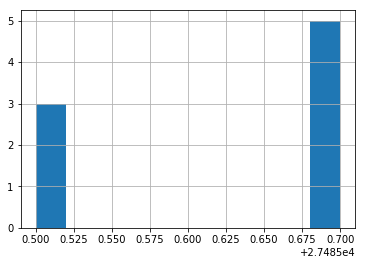

27   2.70  2.80  5      27485.400  27485.600 


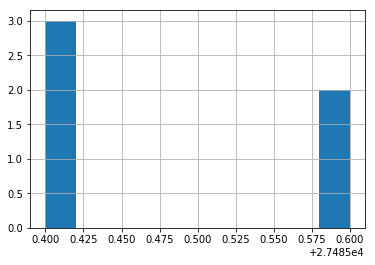

28   2.80  2.90  15     27485.000  27485.100 


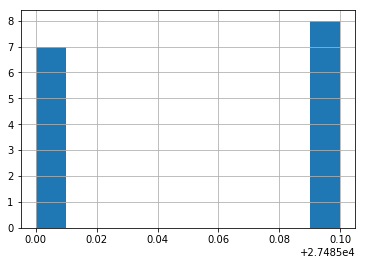

29   2.90  3.00  10     27485.000  27485.500 


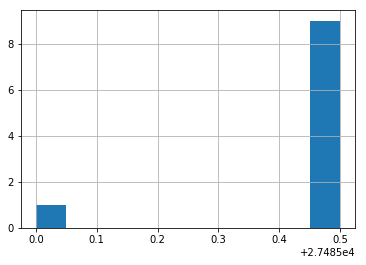

30   3.00  3.10  3      27486.300  27486.300 


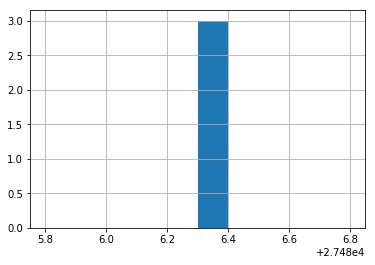

31   3.10  3.20  16     27486.600  27487.200 


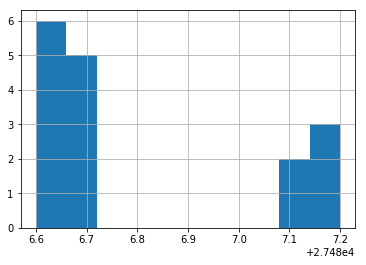

32   3.20  3.30  5      27489.000  27489.000 


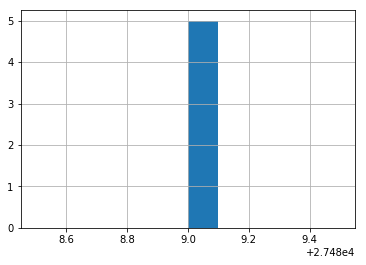

33   3.30  3.40  7      27490.000  27490.500 


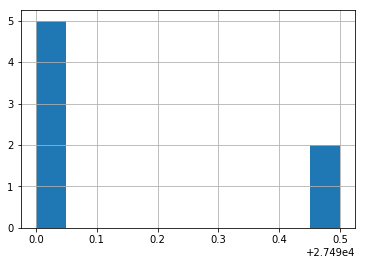

34   3.40  3.50  3      27492.800  27492.900 


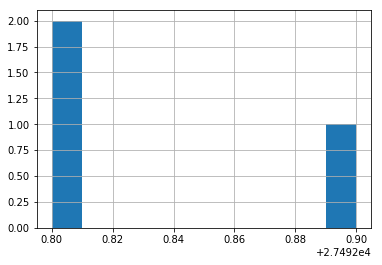

35   3.50  3.60  12     21748.400  27494.300 


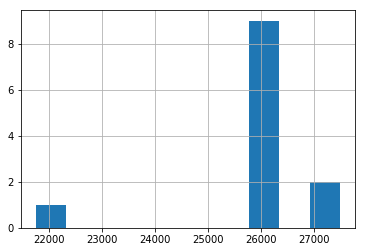

36   3.60  3.70  13     27494.600  27495.200 


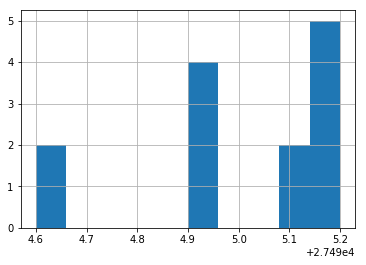

37   3.70  3.80  2      27495.500  27495.500 


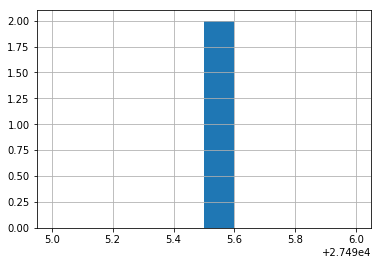

38   3.80  3.90  4      27497.300  27497.400 


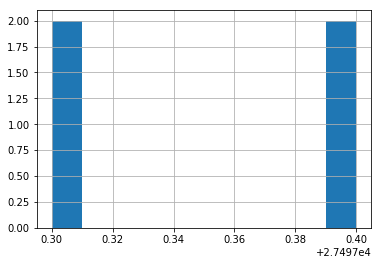

39   3.90  4.00  0      nan        nan       
40   4.00  4.10  0      nan        nan       


In [30]:
mean_bg_mean = []
mean_gps_alt_vals = []
median_gps_alt_vals = []
quantile_025_gps_alt_vals = []
quantile_975_gps_alt_vals = []
std_gps_alt_vals = []
count_gps_alt_vals = []

filtered_df = filtered_background_df

bin_width = 0.10
for i in range(0,math.ceil(4/bin_width)+1):
    min_v = i*bin_width
    max_v = min_v + bin_width
    t_filtered_df = filtered_df[(min_v <= filtered_df.bg_mean) & (filtered_df.bg_mean < max_v)]
    print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
        i, min_v, max_v, len(t_filtered_df), t_filtered_df.gps_alt_mean.min(), t_filtered_df.gps_alt_mean.max()
    ))
    if len(t_filtered_df) > 0:
        t_filtered_df.gps_alt_mean.hist()
        plt.show()
        
        mean_bg_mean.append(np.mean([min_v,max_v]))
        mean_gps_alt_vals.append(t_filtered_df.gps_alt_mean.mean())
        median_gps_alt_vals.append(t_filtered_df.gps_alt_mean.median())
        quantile_025_gps_alt_vals.append(t_filtered_df.gps_alt_mean.quantile(0.025))
        quantile_975_gps_alt_vals.append(t_filtered_df.gps_alt_mean.quantile(0.975))
        std_gps_alt_vals.append(t_filtered_df.gps_alt_mean.std())
        count_gps_alt_vals.append(t_filtered_df.gps_alt_mean.count())
    
# filtered_df 

In [31]:
print('mean_bg_mean')
print(['{:.2f}'.format(v) for v in mean_bg_mean])
print('mean_gps_alt_vals')
print(['{:.2f}'.format(v) for v in mean_gps_alt_vals])
print('median_gps_alt_vals')
print(['{:.2f}'.format(v) for v in median_gps_alt_vals])
print('quantile_025_gps_alt_vals')
print(['{:.2f}'.format(v) for v in quantile_025_gps_alt_vals])
print('quantile_975_gps_alt_vals')
print(['{:.2f}'.format(v) for v in quantile_975_gps_alt_vals])
print('std_gps_alt_vals')
print(['{:.2f}'.format(v) for v in std_gps_alt_vals])
print('count_gps_alt_vals')
print(['{:.2f}'.format(v) for v in count_gps_alt_vals])

mean_bg_mean
['0.85', '0.95', '1.05', '1.15', '1.25', '1.35', '1.45', '1.55', '1.65', '1.75', '1.85', '1.95', '2.05', '2.15', '2.25', '2.35', '2.45', '2.55', '2.65', '2.75', '2.85', '2.95', '3.05', '3.15', '3.25', '3.35', '3.45', '3.55', '3.65', '3.75', '3.85']
mean_gps_alt_vals
['27696.99', '27511.77', '27081.04', '26863.85', '27299.38', '26924.32', '26643.56', '23565.87', '22814.84', '26216.37', '26248.12', '19950.84', '24478.52', '24743.70', '24845.42', '27488.81', '20339.58', '19986.02', '27485.62', '27485.48', '27485.05', '27485.45', '27486.30', '27486.81', '27489.00', '27490.14', '27492.83', '25928.98', '27495.00', '27495.50', '27497.35']
median_gps_alt_vals
['27670.85', '27468.20', '27462.20', '27483.30', '27555.00', '27562.30', '27512.60', '24829.10', '22480.20', '27679.70', '27807.25', '18280.10', '24252.30', '24323.20', '24394.70', '27488.85', '19061.90', '19075.55', '27485.70', '27485.40', '27485.10', '27485.50', '27486.30', '27486.70', '27489.00', '27490.00', '27492.80', '2

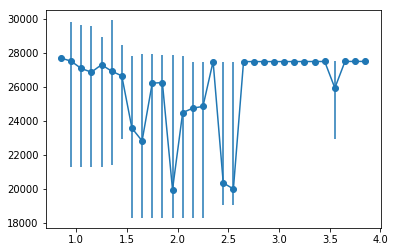

In [32]:
yerr=[np.array(mean_gps_alt_vals) - np.array(quantile_025_gps_alt_vals), 
      np.array(quantile_975_gps_alt_vals) - np.array(mean_gps_alt_vals)]
plt.errorbar(mean_bg_mean, mean_gps_alt_vals, marker='o', yerr=yerr)
plt.show()

In [33]:
# probably not correct
# inspired by https://machinelearningmastery.com/confidence-intervals-for-machine-learning/
def bootstrap_quantiles(df, p, bootstrap_size=100):
    means = np.zeros(bootstrap_size)
    for i in range(bootstrap_size):
        indices = np.random.randint(0, len(df), 500)
        means[i]=df.iloc[indices][p].mean()
    return np.percentile(means,2.5),np.percentile(means,50),np.percentile(means,97.5)

0    16000.00 18000.00 174    1.204      1.838     


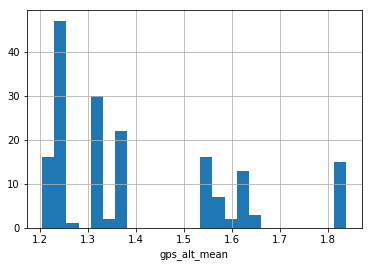

1    18000.00 20000.00 3533   1.154      2.599     


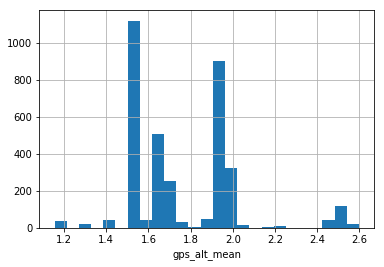

2    20000.00 22000.00 3734   0.984      3.534     


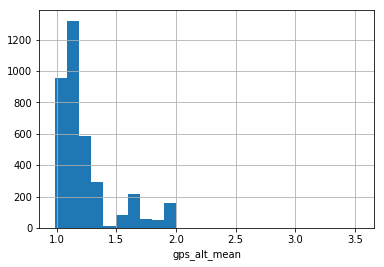

3    22000.00 24000.00 1891   0.906      12.982    


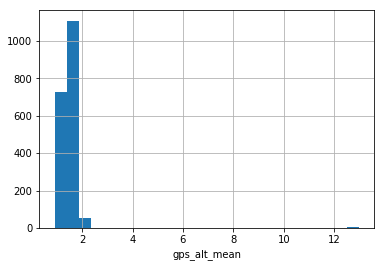

4    24000.00 26000.00 3585   1.093      2.237     


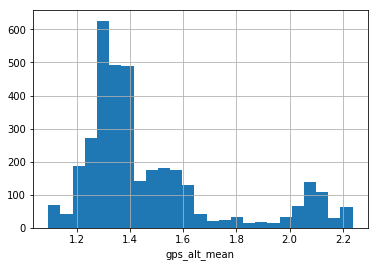

5    26000.00 28000.00 31322  0.876      3.850     


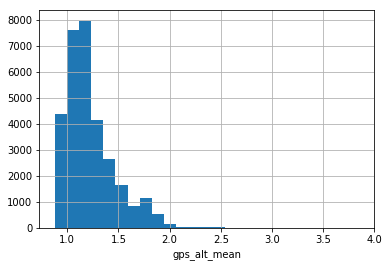

6    28000.00 30000.00 12806  0.899      1.424     


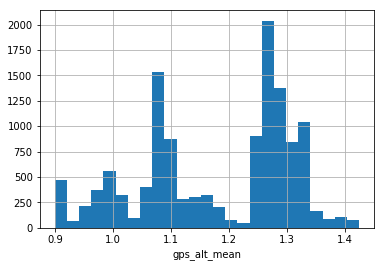

7    30000.00 32000.00 0      nan        nan       
8    32000.00 34000.00 0      nan        nan       
9    34000.00 36000.00 0      nan        nan       
10   36000.00 38000.00 0      nan        nan       


In [34]:
mean_gps_alt = []
mean_bg_mean_vals = []
median_bg_mean_vals = []
quantile_025_bg_mean_vals = []
quantile_975_bg_mean_vals = []
std_bg_mean_vals = []
count_bg_mean_vals = []

b_median_bg_mean_vals = []
b_quantile_025_bg_mean_vals = []
b_quantile_975_bg_mean_vals = []

filtered_df = filtered_background_df

bins_offset = 16000
bin_width = 2000

for i in range(0,math.ceil((36000 - bins_offset)/bin_width)+1):
    min_v = bins_offset + i*bin_width
    max_v = min_v + bin_width
    t_filtered_df = filtered_df[(min_v <= filtered_df.gps_alt_mean) & (filtered_df.gps_alt_mean < max_v)]
    print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
        i, min_v, max_v, len(t_filtered_df), t_filtered_df.bg_mean.min(), t_filtered_df.bg_mean.max()
    ))
    if len(t_filtered_df) > 0:
        h = t_filtered_df.bg_mean.hist(bins=25)
        h.set_xlabel('gps_alt_mean')
        plt.show()
        
        mean_gps_alt.append(np.mean([min_v,max_v]))
        mean_bg_mean_vals.append(t_filtered_df.bg_mean.mean())
        median_bg_mean_vals.append(t_filtered_df.bg_mean.median())
        quantile_025_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.025))
        quantile_975_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.975))
        std_bg_mean_vals.append(t_filtered_df.bg_mean.std())
        count_bg_mean_vals.append(t_filtered_df.bg_mean.count())
        
        b_q025, b_m, b_q975 = bootstrap_quantiles(t_filtered_df, 'bg_mean')
        b_median_bg_mean_vals.append(b_m)
        b_quantile_025_bg_mean_vals.append(b_q025)
        b_quantile_975_bg_mean_vals.append(b_q975)
        
    
# filtered_df 

In [35]:
print('mean_gps_alt')
print(['{:.2f}'.format(v) for v in mean_gps_alt])
print('mean_bg_mean_vals')
print(['{:.2f}'.format(v) for v in mean_bg_mean_vals])
print('median_bg_mean_vals')
print(['{:.2f}'.format(v) for v in median_bg_mean_vals])
print('quantile_025_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_025_bg_mean_vals])
print('quantile_975_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_975_bg_mean_vals])
print('std_bg_mean_vals')
print(['{:.2f}'.format(v) for v in std_bg_mean_vals])
print('count_bg_mean_vals')
print(['{:.2f}'.format(v) for v in count_bg_mean_vals])
print('b_median_bg_mean_vals')
print(['{:.2f}'.format(v) for v in b_median_bg_mean_vals])
print('b_quantile_025_bg_mean_vals')
print(['{:.2f}'.format(v) for v in b_quantile_025_bg_mean_vals])
print('b_quantile_975_bg_mean_vals')
print(['{:.2f}'.format(v) for v in b_quantile_975_bg_mean_vals])

mean_gps_alt
['17000.00', '19000.00', '21000.00', '23000.00', '25000.00', '27000.00', '29000.00']
mean_bg_mean_vals
['1.40', '1.76', '1.23', '1.48', '1.48', '1.23', '1.18']
median_bg_mean_vals
['1.32', '1.67', '1.15', '1.46', '1.37', '1.16', '1.24']
quantile_025_bg_mean_vals
['1.21', '1.43', '0.99', '0.92', '1.16', '0.94', '0.91']
quantile_975_bg_mean_vals
['1.84', '2.50', '1.96', '1.88', '2.15', '1.84', '1.35']
std_bg_mean_vals
['0.19', '0.26', '0.25', '0.59', '0.27', '0.27', '0.13']
count_bg_mean_vals
['174.00', '3533.00', '3734.00', '1891.00', '3585.00', '31322.00', '12806.00']
b_median_bg_mean_vals
['1.40', '1.76', '1.23', '1.48', '1.47', '1.23', '1.18']
b_quantile_025_bg_mean_vals
['1.39', '1.74', '1.21', '1.44', '1.45', '1.21', '1.17']
b_quantile_975_bg_mean_vals
['1.42', '1.79', '1.26', '1.53', '1.50', '1.25', '1.19']


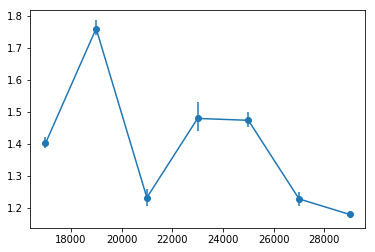

In [36]:
# probably incorrect
yerr=[np.array(b_median_bg_mean_vals) - np.array(b_quantile_025_bg_mean_vals), 
      np.array(b_quantile_975_bg_mean_vals) - np.array(b_median_bg_mean_vals)]
plt.errorbar(mean_gps_alt, b_median_bg_mean_vals, marker='o', yerr=yerr)
plt.show()

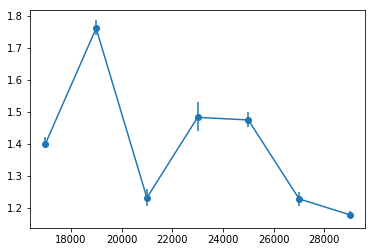

In [37]:
# probably incorrect
yerr=[np.array(mean_bg_mean_vals) - np.array(b_quantile_025_bg_mean_vals), 
      np.array(b_quantile_975_bg_mean_vals) - np.array(mean_bg_mean_vals)]
plt.errorbar(mean_gps_alt, mean_bg_mean_vals, marker='o', yerr=yerr)
plt.show()

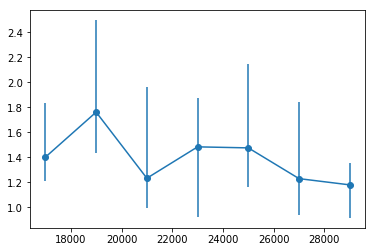

In [38]:
yerr=[np.array(mean_bg_mean_vals) - np.array(quantile_025_bg_mean_vals), 
      np.array(quantile_975_bg_mean_vals) - np.array(mean_bg_mean_vals)]
plt.errorbar(mean_gps_alt, mean_bg_mean_vals, marker='o', yerr=yerr)
plt.show()

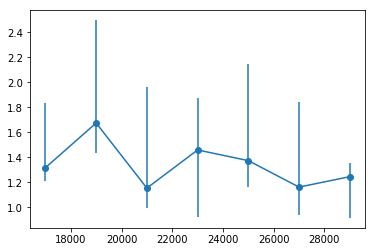

In [39]:
yerr=[np.array(median_bg_mean_vals) - np.array(quantile_025_bg_mean_vals), 
      np.array(quantile_975_bg_mean_vals) - np.array(median_bg_mean_vals)]
plt.errorbar(mean_gps_alt, median_bg_mean_vals, marker='o', yerr=yerr)
plt.show()

## Background - time relation

In [40]:
print(filtered_background_df.gtu_datetime_min.min())
print(filtered_background_df.gtu_datetime_min.min().timestamp())

2017-04-27 08:25:12.981838
1493274312.981838


In [41]:
print(len(filtered_background_df))

57045


0    1493274312.98 (2017-04-27 06:25:12.981838) 1493281512.98 (2017-04-27 08:25:12.981838) 0      nan        nan       
1    1493281512.98 (2017-04-27 08:25:12.981838) 1493288712.98 (2017-04-27 10:25:12.981838) 2556   0.986      1.115     


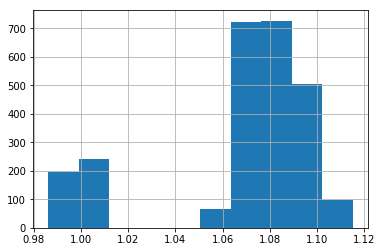

2    1493288712.98 (2017-04-27 10:25:12.981838) 1493295912.98 (2017-04-27 12:25:12.981838) 468    1.053      1.110     


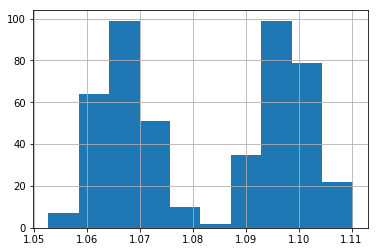

3    1493295912.98 (2017-04-27 12:25:12.981838) 1493303112.98 (2017-04-27 14:25:12.981838) 178    1.271      1.299     


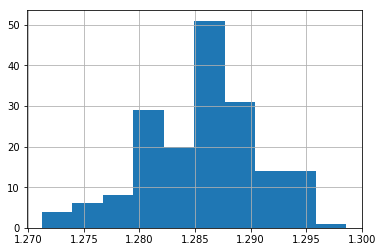

4    1493303112.98 (2017-04-27 14:25:12.981838) 1493310312.98 (2017-04-27 16:25:12.981838) 0      nan        nan       
5    1493310312.98 (2017-04-27 16:25:12.981838) 1493317512.98 (2017-04-27 18:25:12.981838) 0      nan        nan       
6    1493317512.98 (2017-04-27 18:25:12.981838) 1493324712.98 (2017-04-27 20:25:12.981838) 0      nan        nan       
7    1493324712.98 (2017-04-27 20:25:12.981838) 1493331912.98 (2017-04-27 22:25:12.981838) 0      nan        nan       
8    1493331912.98 (2017-04-27 22:25:12.981838) 1493339112.98 (2017-04-28 00:25:12.981838) 0      nan        nan       
9    1493339112.98 (2017-04-28 00:25:12.981838) 1493346312.98 (2017-04-28 02:25:12.981838) 0      nan        nan       
10   1493346312.98 (2017-04-28 02:25:12.981838) 1493353512.98 (2017-04-28 04:25:12.981838) 0      nan        nan       
11   1493353512.98 (2017-04-28 04:25:12.981838) 1493360712.98 (2017-04-28 06:25:12.981838) 0      nan        nan       
12   1493360712.98 (2017-04-28 06:25:12.

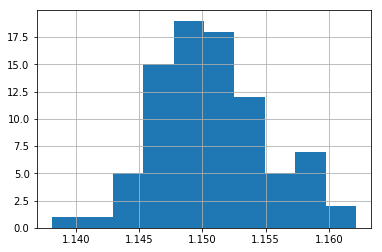

13   1493367912.98 (2017-04-28 08:25:12.981838) 1493375112.98 (2017-04-28 10:25:12.981838) 7798   0.933      1.424     


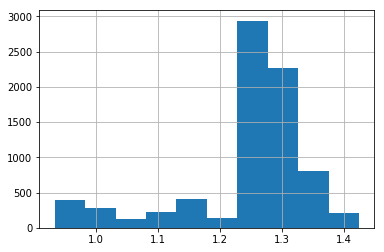

14   1493375112.98 (2017-04-28 10:25:12.981838) 1493382312.98 (2017-04-28 12:25:12.981838) 663    1.641      1.862     


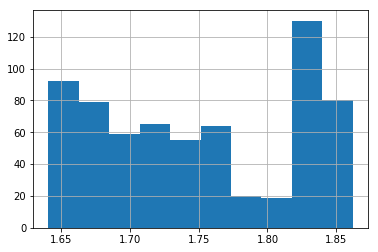

15   1493382312.98 (2017-04-28 12:25:12.981838) 1493389512.98 (2017-04-28 14:25:12.981838) 8892   1.042      2.003     


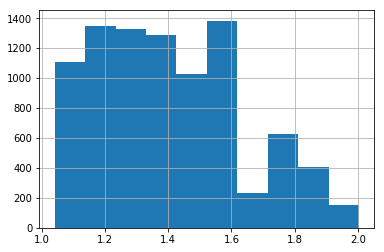

16   1493389512.98 (2017-04-28 14:25:12.981838) 1493396712.98 (2017-04-28 16:25:12.981838) 11005  0.926      1.459     


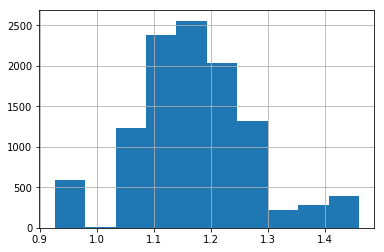

17   1493396712.98 (2017-04-28 16:25:12.981838) 1493403912.98 (2017-04-28 18:25:12.981838) 5038   0.930      3.850     


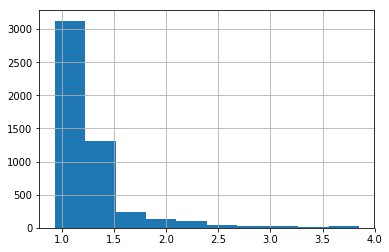

18   1493403912.98 (2017-04-28 18:25:12.981838) 1493411112.98 (2017-04-28 20:25:12.981838) 0      nan        nan       
19   1493411112.98 (2017-04-28 20:25:12.981838) 1493418312.98 (2017-04-28 22:25:12.981838) 0      nan        nan       
20   1493418312.98 (2017-04-28 22:25:12.981838) 1493425512.98 (2017-04-29 00:25:12.981838) 0      nan        nan       
21   1493425512.98 (2017-04-29 00:25:12.981838) 1493432712.98 (2017-04-29 02:25:12.981838) 0      nan        nan       
22   1493432712.98 (2017-04-29 02:25:12.981838) 1493439912.98 (2017-04-29 04:25:12.981838) 0      nan        nan       
23   1493439912.98 (2017-04-29 04:25:12.981838) 1493447112.98 (2017-04-29 06:25:12.981838) 424    1.164      1.324     


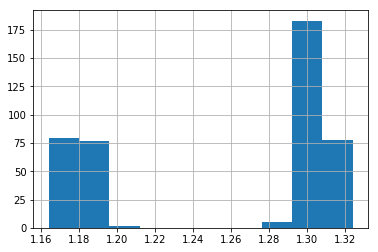

24   1493447112.98 (2017-04-29 06:25:12.981838) 1493454312.98 (2017-04-29 08:25:12.981838) 5360   0.876      1.172     


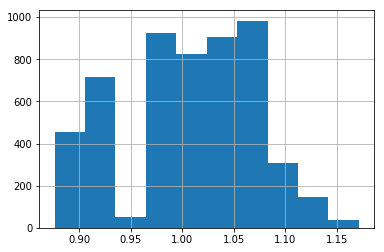

25   1493454312.98 (2017-04-29 08:25:12.981838) 1493461512.98 (2017-04-29 10:25:12.981838) 6409   0.987      2.237     


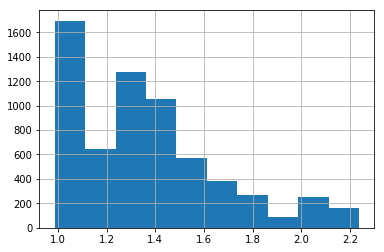

26   1493461512.98 (2017-04-29 10:25:12.981838) 1493468712.98 (2017-04-29 12:25:12.981838) 2645   0.984      1.978     


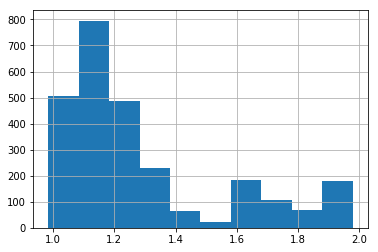

27   1493468712.98 (2017-04-29 12:25:12.981838) 1493475912.98 (2017-04-29 14:25:12.981838) 678    1.007      1.217     


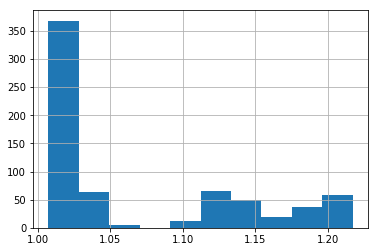

28   1493475912.98 (2017-04-29 14:25:12.981838) 1493483112.98 (2017-04-29 16:25:12.981838) 756    1.081      1.552     


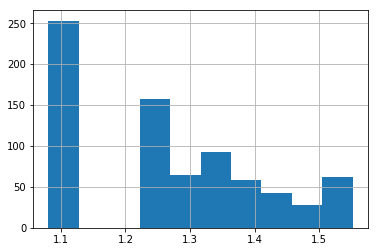

29   1493483112.98 (2017-04-29 16:25:12.981838) 1493490312.98 (2017-04-29 18:25:12.981838) 92     1.594      12.982    


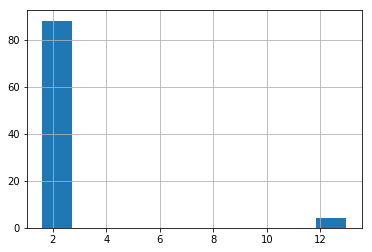

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
12.9777
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
30   1493490312.98 (2017-04-29 18:25:12.981838) 1493497512.98 (2017-04-29 20:25:12.981838) 0      nan        nan       
31   1493497512.98 (2017-04-29 20:25:12.981838) 1493504712.98 (2017-04-29 22:25:12.981838) 0      nan        nan       
32   1493504712.98 (2017-04-29 22:25:12.981838) 1493511912.98 (2017-04-30 00:25:12.981838) 0      nan        nan       
33   1493511912.98 (2017-04-30 00:25:12.981838) 1493519112.98 (2017-04-30 02:25:12.981838) 0      nan        nan       
34   1493519112.98 (2017-04-30 02:25:12.981838) 1493526312.98 (2017-04-30 04:25:12.981838) 0      nan        nan       
35   1493526312.98 (2017-04-30 04:25:12.981838) 1493533512.98 (2017-04-30 06:25:12.981838) 0      nan        nan       
36   1493533512.98 (2017-04-30 06:25:12.981838) 1493540712.98 (2017-04-30 08:25:12.981838) 177    2.465      2.599     


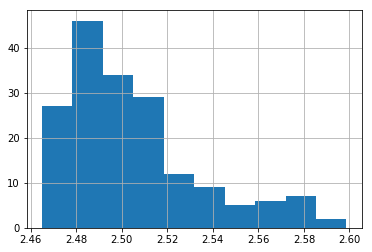

37   1493540712.98 (2017-04-30 08:25:12.981838) 1493547912.98 (2017-04-30 10:25:12.981838) 24     1.539      1.585     


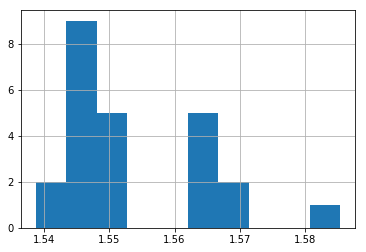

38   1493547912.98 (2017-04-30 10:25:12.981838) 1493555112.98 (2017-04-30 12:25:12.981838) 54     1.306      1.380     


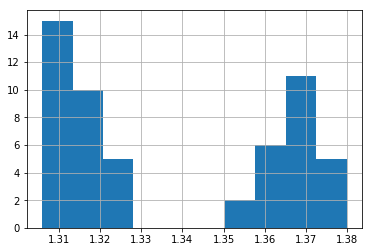

39   1493555112.98 (2017-04-30 12:25:12.981838) 1493562312.98 (2017-04-30 14:25:12.981838) 16     1.204      1.216     


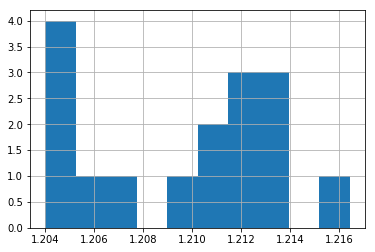

40   1493562312.98 (2017-04-30 14:25:12.981838) 1493569512.98 (2017-04-30 16:25:12.981838) 47     1.240      1.838     


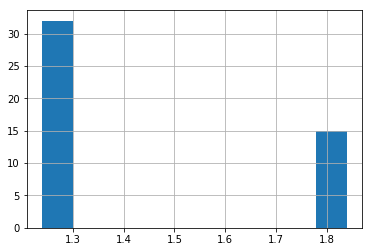

41   1493569512.98 (2017-04-30 16:25:12.981838) 1493576712.98 (2017-04-30 18:25:12.981838) 0      nan        nan       
42   1493576712.98 (2017-04-30 18:25:12.981838) 1493583912.98 (2017-04-30 20:25:12.981838) 0      nan        nan       
43   1493583912.98 (2017-04-30 20:25:12.981838) 1493591112.98 (2017-04-30 22:25:12.981838) 0      nan        nan       
44   1493591112.98 (2017-04-30 22:25:12.981838) 1493598312.98 (2017-05-01 00:25:12.981838) 0      nan        nan       
45   1493598312.98 (2017-05-01 00:25:12.981838) 1493605512.98 (2017-05-01 02:25:12.981838) 0      nan        nan       
46   1493605512.98 (2017-05-01 02:25:12.981838) 1493612712.98 (2017-05-01 04:25:12.981838) 0      nan        nan       
47   1493612712.98 (2017-05-01 04:25:12.981838) 1493619912.98 (2017-05-01 06:25:12.981838) 0      nan        nan       
48   1493619912.98 (2017-05-01 06:25:12.981838) 1493627112.98 (2017-05-01 08:25:12.981838) 9      3.526      3.531     


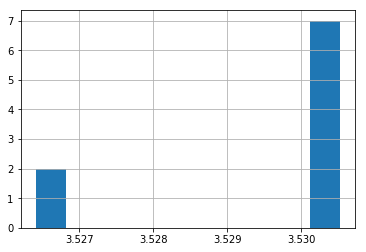

49   1493627112.98 (2017-05-01 08:25:12.981838) 1493634312.98 (2017-05-01 10:25:12.981838) 6      1.395      1.411     


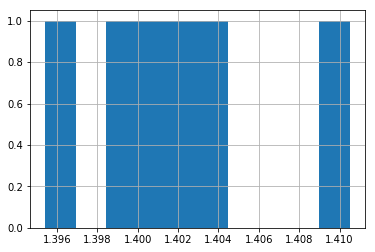

50   1493634312.98 (2017-05-01 10:25:12.981838) 1493641512.98 (2017-05-01 12:25:12.981838) 38     1.387      1.645     


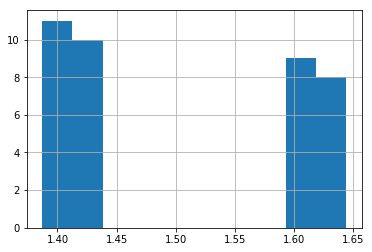

51   1493641512.98 (2017-05-01 12:25:12.981838) 1493648712.98 (2017-05-01 14:25:12.981838) 40     1.502      3.534     


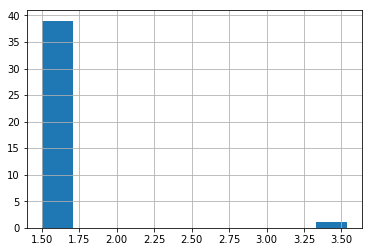

52   1493648712.98 (2017-05-01 14:25:12.981838) 1493655912.98 (2017-05-01 16:25:12.981838) 0      nan        nan       
53   1493655912.98 (2017-05-01 16:25:12.981838) 1493663112.98 (2017-05-01 18:25:12.981838) 0      nan        nan       
54   1493663112.98 (2017-05-01 18:25:12.981838) 1493670312.98 (2017-05-01 20:25:12.981838) 0      nan        nan       
55   1493670312.98 (2017-05-01 20:25:12.981838) 1493677512.98 (2017-05-01 22:25:12.981838) 0      nan        nan       
56   1493677512.98 (2017-05-01 22:25:12.981838) 1493684712.98 (2017-05-02 00:25:12.981838) 0      nan        nan       
57   1493684712.98 (2017-05-02 00:25:12.981838) 1493691912.98 (2017-05-02 02:25:12.981838) 0      nan        nan       
58   1493691912.98 (2017-05-02 02:25:12.981838) 1493699112.98 (2017-05-02 04:25:12.981838) 0      nan        nan       
59   1493699112.98 (2017-05-02 04:25:12.981838) 1493706312.98 (2017-05-02 06:25:12.981838) 0      nan        nan       
60   1493706312.98 (2017-05-02 06:25:12.

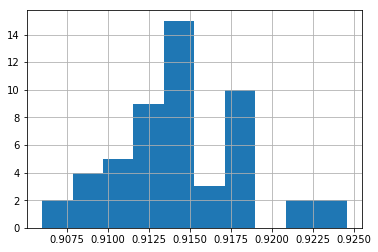

62   1493720712.98 (2017-05-02 10:25:12.981838) 1493727912.98 (2017-05-02 12:25:12.981838) 35     1.247      1.269     


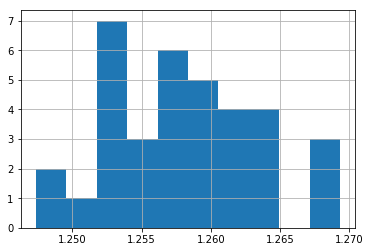

63   1493727912.98 (2017-05-02 12:25:12.981838) 1493735112.98 (2017-05-02 14:25:12.981838) 29     1.883      1.973     


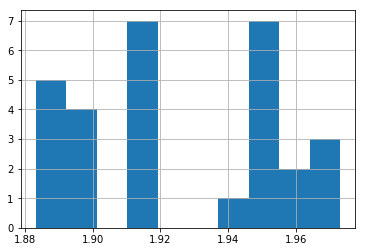

64   1493735112.98 (2017-05-02 14:25:12.981838) 1493742312.98 (2017-05-02 16:25:12.981838) 16     1.879      1.902     


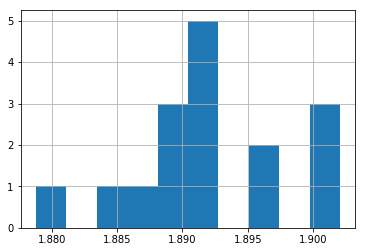

65   1493742312.98 (2017-05-02 16:25:12.981838) 1493749512.98 (2017-05-02 18:25:12.981838) 0      nan        nan       
66   1493749512.98 (2017-05-02 18:25:12.981838) 1493756712.98 (2017-05-02 20:25:12.981838) 0      nan        nan       
67   1493756712.98 (2017-05-02 20:25:12.981838) 1493763912.98 (2017-05-02 22:25:12.981838) 0      nan        nan       
68   1493763912.98 (2017-05-02 22:25:12.981838) 1493771112.98 (2017-05-03 00:25:12.981838) 0      nan        nan       
69   1493771112.98 (2017-05-03 00:25:12.981838) 1493778312.98 (2017-05-03 02:25:12.981838) 0      nan        nan       
70   1493778312.98 (2017-05-03 02:25:12.981838) 1493785512.98 (2017-05-03 04:25:12.981838) 0      nan        nan       
71   1493785512.98 (2017-05-03 04:25:12.981838) 1493792712.98 (2017-05-03 06:25:12.981838) 0      nan        nan       
72   1493792712.98 (2017-05-03 06:25:12.981838) 1493799912.98 (2017-05-03 08:25:12.981838) 0      nan        nan       
73   1493799912.98 (2017-05-03 08:25:12.

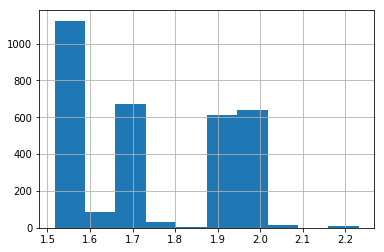

74   1493807112.98 (2017-05-03 10:25:12.981838) 1493814312.98 (2017-05-03 12:25:12.981838) 41     1.416      1.438     


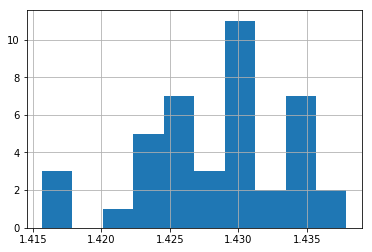

75   1493814312.98 (2017-05-03 12:25:12.981838) 1493821512.98 (2017-05-03 14:25:12.981838) 28     1.577      1.601     


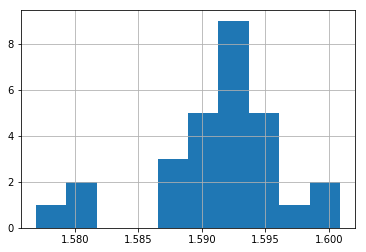

76   1493821512.98 (2017-05-03 14:25:12.981838) 1493828712.98 (2017-05-03 16:25:12.981838) 0      nan        nan       
77   1493828712.98 (2017-05-03 16:25:12.981838) 1493835912.98 (2017-05-03 18:25:12.981838) 0      nan        nan       
78   1493835912.98 (2017-05-03 18:25:12.981838) 1493843112.98 (2017-05-03 20:25:12.981838) 0      nan        nan       
79   1493843112.98 (2017-05-03 20:25:12.981838) 1493850312.98 (2017-05-03 22:25:12.981838) 0      nan        nan       
80   1493850312.98 (2017-05-03 22:25:12.981838) 1493857512.98 (2017-05-04 00:25:12.981838) 0      nan        nan       
81   1493857512.98 (2017-05-04 00:25:12.981838) 1493864712.98 (2017-05-04 02:25:12.981838) 0      nan        nan       
82   1493864712.98 (2017-05-04 02:25:12.981838) 1493871912.98 (2017-05-04 04:25:12.981838) 0      nan        nan       
83   1493871912.98 (2017-05-04 04:25:12.981838) 1493879112.98 (2017-05-04 06:25:12.981838) 0      nan        nan       
84   1493879112.98 (2017-05-04 06:25:12.

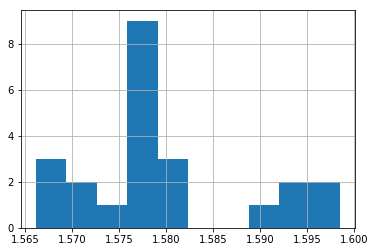

87   1493900712.98 (2017-05-04 12:25:12.981838) 1493907912.98 (2017-05-04 14:25:12.981838) 47     1.154      1.733     


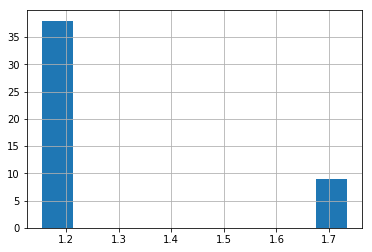

88   1493907912.98 (2017-05-04 14:25:12.981838) 1493915112.98 (2017-05-04 16:25:12.981838) 0      nan        nan       
89   1493915112.98 (2017-05-04 16:25:12.981838) 1493922312.98 (2017-05-04 18:25:12.981838) 0      nan        nan       
90   1493922312.98 (2017-05-04 18:25:12.981838) 1493929512.98 (2017-05-04 20:25:12.981838) 0      nan        nan       
91   1493929512.98 (2017-05-04 20:25:12.981838) 1493936712.98 (2017-05-04 22:25:12.981838) 0      nan        nan       
92   1493936712.98 (2017-05-04 22:25:12.981838) 1493943912.98 (2017-05-05 00:25:12.981838) 0      nan        nan       
93   1493943912.98 (2017-05-05 00:25:12.981838) 1493951112.98 (2017-05-05 02:25:12.981838) 0      nan        nan       
94   1493951112.98 (2017-05-05 02:25:12.981838) 1493958312.98 (2017-05-05 04:25:12.981838) 0      nan        nan       
95   1493958312.98 (2017-05-05 04:25:12.981838) 1493965512.98 (2017-05-05 06:25:12.981838) 0      nan        nan       
96   1493965512.98 (2017-05-05 06:25:12.

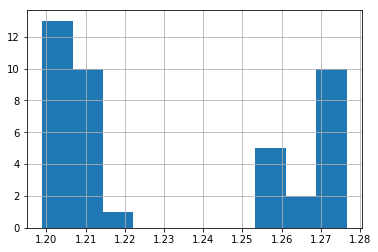

98   1493979912.98 (2017-05-05 10:25:12.981838) 1493987112.98 (2017-05-05 12:25:12.981838) 40     1.305      1.348     


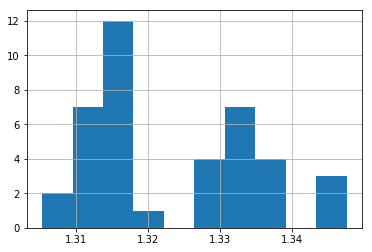

99   1493987112.98 (2017-05-05 12:25:12.981838) 1493994312.98 (2017-05-05 14:25:12.981838) 0      nan        nan       
100  1493994312.98 (2017-05-05 14:25:12.981838) 1494001512.98 (2017-05-05 16:25:12.981838) 0      nan        nan       
101  1494001512.98 (2017-05-05 16:25:12.981838) 1494008712.98 (2017-05-05 18:25:12.981838) 0      nan        nan       
102  1494008712.98 (2017-05-05 18:25:12.981838) 1494015912.98 (2017-05-05 20:25:12.981838) 0      nan        nan       
103  1494015912.98 (2017-05-05 20:25:12.981838) 1494023112.98 (2017-05-05 22:25:12.981838) 0      nan        nan       
104  1494023112.98 (2017-05-05 22:25:12.981838) 1494030312.98 (2017-05-06 00:25:12.981838) 0      nan        nan       
105  1494030312.98 (2017-05-06 00:25:12.981838) 1494037512.98 (2017-05-06 02:25:12.981838) 0      nan        nan       
106  1494037512.98 (2017-05-06 02:25:12.981838) 1494044712.98 (2017-05-06 04:25:12.981838) 0      nan        nan       
107  1494044712.98 (2017-05-06 04:25:12.

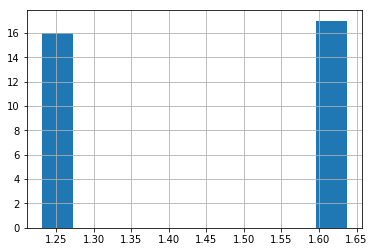

In [42]:
filtered_df = filtered_background_df

bins_offset = filtered_df.gtu_datetime_min.min().timestamp()
bins_range_end = filtered_df.gtu_datetime_min.max().timestamp()
bin_width = 3600*2

mean_gtu_datetime_vals = []
mean_bg_mean_vals = []
median_bg_mean_vals = []
quantile_025_bg_mean_vals = []
quantile_975_bg_mean_vals = []
std_bg_mean_vals = []
count_bg_mean_vals = []


for i in range(0,math.ceil((bins_range_end - bins_offset)/bin_width)+1):
    min_v = bins_offset + i*bin_width
    max_v = min_v + bin_width
    t_filtered_df = filtered_df[
        (datetime.datetime.utcfromtimestamp(min_v) <= filtered_df.gtu_datetime_min) \
        & (filtered_df.gtu_datetime_min < datetime.datetime.utcfromtimestamp(max_v))]
    print("{:<4d} {:<5.2f} ({}) {:<5.2f} ({}) {:<6d} {:<10.3f} {:<10.3f}".format(
        i, min_v, datetime.datetime.utcfromtimestamp(min_v), max_v, datetime.datetime.utcfromtimestamp(max_v),
        len(t_filtered_df), t_filtered_df.bg_mean.min(), t_filtered_df.bg_mean.max()
    ))
    if len(t_filtered_df) > 0:
        t_filtered_df.bg_mean.hist()
        plt.show()
        
        mean_gtu_datetime_vals.append(datetime.datetime.utcfromtimestamp(np.mean([min_v,max_v])))
        mean_bg_mean_vals.append(t_filtered_df.bg_mean.mean())
        median_bg_mean_vals.append(t_filtered_df.bg_mean.median())
        quantile_025_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.025))
        quantile_975_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.975))
        if quantile_975_bg_mean_vals[-1] > 8:
            print('!'*30)
            print(quantile_975_bg_mean_vals[-1])
            print('!'*30)
        std_bg_mean_vals.append(t_filtered_df.bg_mean.std())
        count_bg_mean_vals.append(t_filtered_df.bg_mean.count())
                
    
# filtered_df 

In [43]:
print('mean_gtu_datetime_vals')
print([v.isoformat() for v in mean_gtu_datetime_vals])
print('mean_bg_mean_vals')
print(['{:.2f}'.format(v) for v in mean_bg_mean_vals])
print('median_bg_mean_vals')
print(['{:.2f}'.format(v) for v in median_bg_mean_vals])
print('quantile_025_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_025_bg_mean_vals])
print('quantile_975_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_975_bg_mean_vals])
print('std_bg_mean_vals')
print(['{:.2f}'.format(v) for v in std_bg_mean_vals])
print('count_bg_mean_vals')
print(['{:.2f}'.format(v) for v in count_bg_mean_vals])

mean_gtu_datetime_vals
['2017-04-27T09:25:12.981838', '2017-04-27T11:25:12.981838', '2017-04-27T13:25:12.981838', '2017-04-28T07:25:12.981838', '2017-04-28T09:25:12.981838', '2017-04-28T11:25:12.981838', '2017-04-28T13:25:12.981838', '2017-04-28T15:25:12.981838', '2017-04-28T17:25:12.981838', '2017-04-29T05:25:12.981838', '2017-04-29T07:25:12.981838', '2017-04-29T09:25:12.981838', '2017-04-29T11:25:12.981838', '2017-04-29T13:25:12.981838', '2017-04-29T15:25:12.981838', '2017-04-29T17:25:12.981838', '2017-04-30T07:25:12.981838', '2017-04-30T09:25:12.981838', '2017-04-30T11:25:12.981838', '2017-04-30T13:25:12.981838', '2017-04-30T15:25:12.981838', '2017-05-01T07:25:12.981838', '2017-05-01T09:25:12.981838', '2017-05-01T11:25:12.981838', '2017-05-01T13:25:12.981838', '2017-05-02T09:25:12.981838', '2017-05-02T11:25:12.981838', '2017-05-02T13:25:12.981838', '2017-05-02T15:25:12.981838', '2017-05-03T09:25:12.981838', '2017-05-03T11:25:12.981838', '2017-05-03T13:25:12.981838', '2017-05-04T11:2

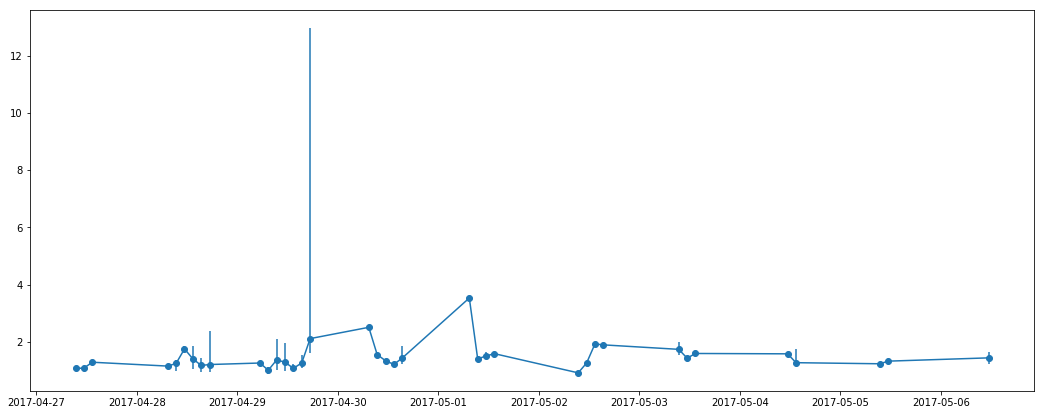

In [44]:
yerr=[np.array(mean_bg_mean_vals) - np.array(quantile_025_bg_mean_vals), 
      np.array(quantile_975_bg_mean_vals) - np.array(mean_bg_mean_vals)]
plt.figure(figsize=(18,7))
plt.errorbar(mean_gtu_datetime_vals, mean_bg_mean_vals, marker='o', yerr=yerr)
plt.show()

In [45]:
print(yerr[0][15],yerr[1][15])
print(mean_bg_mean_vals[15])
print(quantile_975_bg_mean_vals[15])

0.5148857282608701 10.86648152173913
2.11121847826087
12.9777


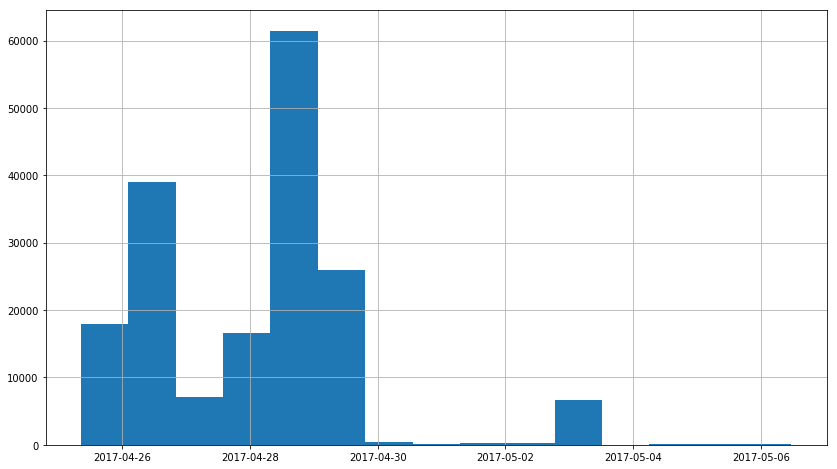

In [46]:
flight_data_df.gtu_datetime_min.hist(bins=15,figsize=(14,8))
plt.show()

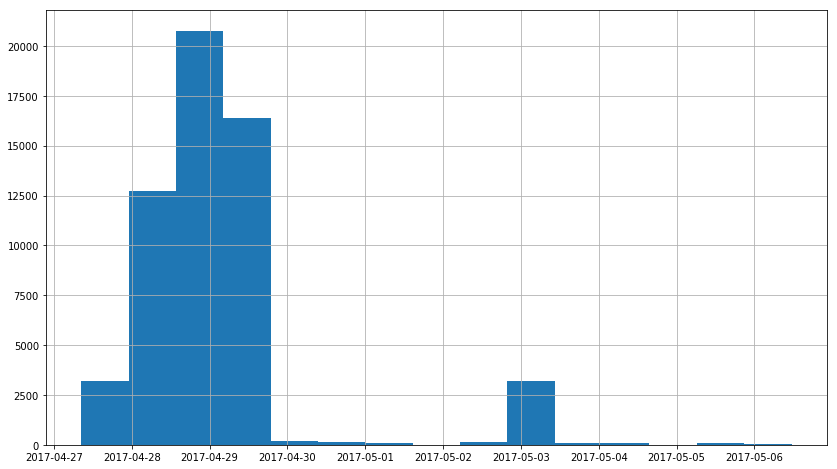

In [47]:
filtered_df.gtu_datetime_min.hist(bins=15,figsize=(14,8))
plt.show()

# Saving table of files and packets

In [48]:
filtered_df = filtered_background_df

table_for_bg_file_path = os.path.join(data_snippets_dir,'ver3_flatmap__bg_size_36__7_ec.tsv')
print(table_for_bg_file_path)
num_uniq = 0
if len(filtered_df) > 0:
    with open(table_for_bg_file_path, 'w+') as table_for_bg_file:
        t_filtered_df_grouped = filtered_df.groupby('source_file_acquisition_full')
        for sfa, sfa_df in t_filtered_df_grouped:
            for r in sfa_df.packet_id.unique():
                num_uniq += 1
                print("{}\t{}".format(sfa, r), file=table_for_bg_file)
print("num_uniq =",num_uniq)

ver3_flatmap_data_snippets/ver3_flatmap__bg_size_36__7_ec.tsv
num_uniq = 32043


In [49]:
filtered_df = filtered_background_df

bins_offset = 0
bins_range = 4

for bin_width in [0.1, 0.2, 0.5, 1.0]:

    table_for_bg_dir_path = os.path.join(data_snippets_dir,'bg_mean__{}_bins'.format(
        '{:.2f}'.format(bin_width).replace('.','_')
    ))
    os.makedirs(table_for_bg_dir_path, exist_ok=True)
    
    table_for_bg_file_path_format = os.path.join(table_for_bg_dir_path,'ver3_flatmap__bg_size_36__7_ec__bg_mean_{}.tsv')
    
    for i in range(0,math.ceil(bins_range/bin_width)+1):
        min_v = bins_offset + i*bin_width
        max_v = min_v + bin_width
        t_filtered_df = filtered_df[(min_v <= filtered_df.bg_mean) & (filtered_df.bg_mean < max_v)]
        print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
            i, min_v, max_v, len(t_filtered_df), t_filtered_df.gps_alt_mean.min(), t_filtered_df.gps_alt_mean.max()
        ))
        if len(t_filtered_df) > 0:
            t_filtered_df_grouped = t_filtered_df.groupby('source_file_acquisition_full')
            
            table_for_bg_file_path = table_for_bg_file_path_format.format(
                '{:.2f}'.format(np.mean([min_v,max_v])).replace('.','_'))
            print(table_for_bg_file_path)
            
            num_uniq = 0
            with open(table_for_bg_file_path, 'w+') as table_for_bg_file:
                for sfa, sfa_df in t_filtered_df_grouped:
                    for r in sfa_df.packet_id.unique():
                        num_uniq += 1
                        print("{}\t{}".format(sfa, r), file=table_for_bg_file)
            print(num_uniq)
            
    print('-'*30)

0    0.00  0.10  0      nan        nan       
1    0.10  0.20  0      nan        nan       
2    0.20  0.30  0      nan        nan       
3    0.30  0.40  0      nan        nan       
4    0.40  0.50  0      nan        nan       
5    0.50  0.60  0      nan        nan       
6    0.60  0.70  0      nan        nan       
7    0.70  0.80  0      nan        nan       
8    0.80  0.90  346    27634.600  28016.100 
ver3_flatmap_data_snippets/bg_mean__0_10_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_0_85.tsv
230
9    0.90  1.00  6056   21239.500  29824.000 
ver3_flatmap_data_snippets/bg_mean__0_10_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_0_95.tsv
3922
10   1.00  1.10  10885  21238.700  29823.900 
ver3_flatmap_data_snippets/bg_mean__0_10_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_1_05.tsv
6431
11   1.10  1.20  9776   19741.700  29695.800 
ver3_flatmap_data_snippets/bg_mean__0_10_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_1_15.tsv
6078
12   1.20  1.30  10881  16905.900  29964.000 
ver

27420
2    2.00  3.00  838    18279.500  27827.900 
ver3_flatmap_data_snippets/bg_mean__1_00_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_2_50.tsv
442
3    3.00  4.00  65     21748.400  27497.400 
ver3_flatmap_data_snippets/bg_mean__1_00_bins/ver3_flatmap__bg_size_36__7_ec__bg_mean_3_50.tsv
27
4    4.00  5.00  0      nan        nan       
------------------------------


In [50]:
flight_data_df[(flight_data_df.bg_size >= 36) & (flight_data_df.bg_size >= 36) & (flight_data_df.gtu_in_packet >= 40)]

,event_id,source_file_acquisition_full,source_file_acquisition,global_gtu,packet_id,gtu_in_packet,num_gtu,gps_lat_mean,gps_lon_mean,gps_alt_mean,...,bg_norm_sum,bg_min,bg_max,bg_mean,bg_std,bg_mean_gz,bg_std_gz,bg_size,bg_median,bg_median_gz
0,1,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,169,1,41,9,-43.8621,172.355,33239.2,...,1793.97,0,12,0.269536,0.772524,1.84672,1.084580,36.0,0.00000,1.43213
1,2,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,222,1,94,9,-43.8621,172.355,33239.2,...,1793.97,0,12,0.269536,0.772524,1.84672,1.084580,36.0,0.00000,1.43213
2,3,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,238,1,110,14,-43.8621,172.355,33239.2,...,1793.97,0,12,0.269536,0.772524,1.84672,1.084580,36.0,0.00000,1.43213
3,4,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,424,3,40,17,-43.8621,172.355,33239.2,...,2258.02,0,9,0.257944,0.725360,1.78128,0.959121,36.0,0.00000,1.41060
4,5,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,445,3,61,10,-43.8621,172.355,33239.2,...,2258.02,0,9,0.257944,0.725360,1.78128,0.959121,36.0,0.00000,1.41060
9,10,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,936,7,40,17,-43.8620,172.355,33238.6,...,2248.31,0,9,0.259015,0.731674,1.79991,0.972973,36.0,0.00000,1.42462
10,11,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,957,7,61,14,-43.8620,172.355,33238.6,...,2248.31,0,9,0.259015,0.731674,1.79991,0.972973,36.0,0.00000,1.42462
23,24,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,1320,10,40,19,-43.8620,172.355,33238.6,...,2066.95,0,10,0.256612,0.727181,1.78936,0.971921,36.0,0.00000,1.41566
24,25,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,1340,10,60,15,-43.8620,172.355,33238.6,...,2066.95,0,10,0.256612,0.727181,1.78936,0.971921,36.0,0.00000,1.41566
30,31,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,allpackets-SPBEUSO-ACQUISITION-20170425-083146...,1576,12,40,9,-43.8620,172.355,33238.3,...,1689.49,0,12,0.253838,0.735916,1.78745,1.035530,36.0,0.00000,1.37630


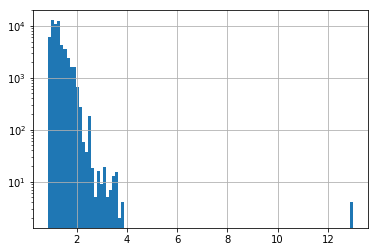

0.9819895000000001
0.9383441642453212


In [51]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
t_filtered_df = flight_data_df[flight_data_df.bg_size >= 36]
h = filtered_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()
print(np.median(t_filtered_df.bg_mean))
print(np.mean(t_filtered_df.bg_mean))

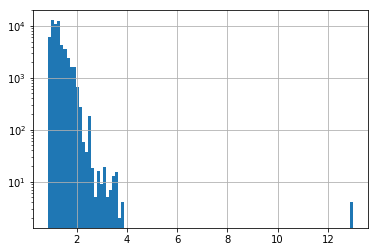

1.08974
1.189834678228826


In [52]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
t_filtered_df = flight_data_df[flight_data_df.bg_size < 36]
h = filtered_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()
print(np.median(t_filtered_df.bg_mean))
print(np.mean(t_filtered_df.bg_mean))

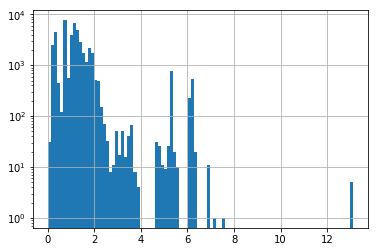

1.09147
1.2498392313288202


In [53]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[flight_data_df.bg_size < 20]
h = filtered_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))

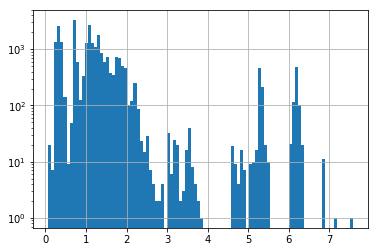

1.08652
1.3277122782803665


In [54]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[flight_data_df.bg_size < 10]
h = filtered_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))

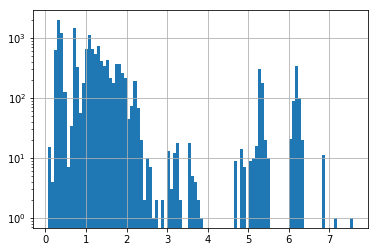

1.07461
1.386818711770951


In [55]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[flight_data_df.bg_size < 5]
h = filtered_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))

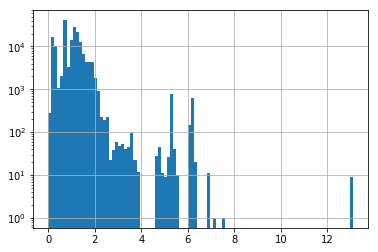

In [56]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_mean.hist(bins=100)
h.set_yscale('log')
plt.show()

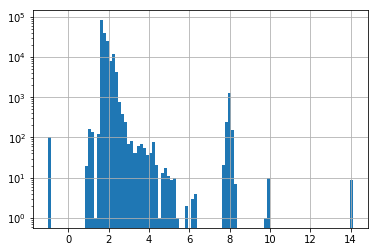

In [57]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_mean_gz.hist(bins=100)
h.set_yscale('log')
plt.show()

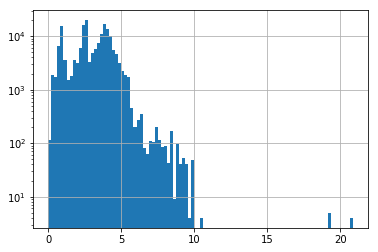

In [58]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_x_y_mean.hist(bins=100)
h.set_yscale('log')
plt.show()

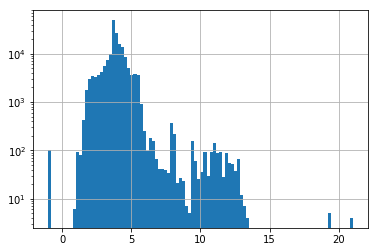

In [59]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_x_y_mean_gz.hist(bins=100)
h.set_yscale('log')
plt.show()

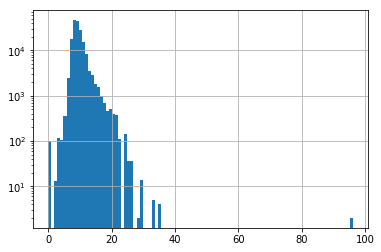

In [60]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_x_y_max.hist(bins=100)
h.set_yscale('log')
plt.show()

In [61]:
import seaborn

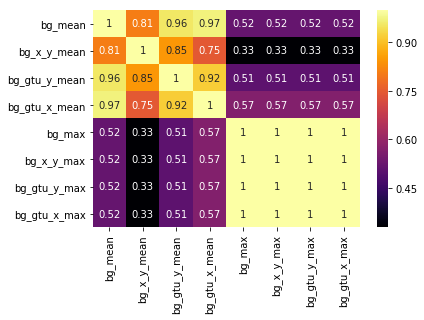

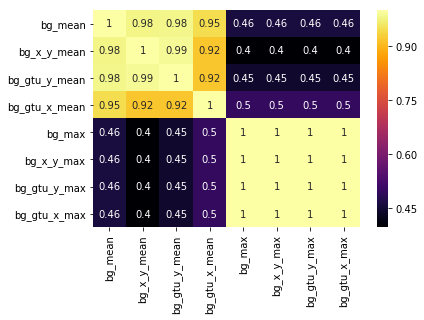

In [62]:
flight_data_corr_df = flight_data_df[['bg_mean','bg_x_y_mean','bg_gtu_y_mean','bg_gtu_x_mean',
                                      'bg_max','bg_x_y_max','bg_gtu_y_max','bg_gtu_x_max']].corr()
f, ax = plt.subplots(figsize=(28,22))

#Draw the heatmap using seaborn
plt.close('all')
seaborn.heatmap(flight_data_corr_df, cmap='inferno', annot=True)
plt.show()

filtered_df = flight_data_df[(flight_data_df.bg_size >= 36) & (flight_data_df.gtu_in_packet >= 40)]
flight_data_corr_df = filtered_df[['bg_mean','bg_x_y_mean','bg_gtu_y_mean','bg_gtu_x_mean',
                                      'bg_max','bg_x_y_max','bg_gtu_y_max','bg_gtu_x_max']].corr()
f, ax = plt.subplots(figsize=(28,22))

#Draw the heatmap using seaborn
plt.close('all')
seaborn.heatmap(flight_data_corr_df, cmap='inferno', annot=True)
plt.show()

In [63]:
# current_columns_for_analysis_dict = split_columns_for_analysis_dict[0]

# select_clause_str, joined_tables_list = \
#     query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
# join_clauses_str = \
#     query_functions.get_query_clauses__join(joined_tables_list)
# where_clauses_str = ' AND config_info_id=2'
    
# events_selection_query = query_functions.get_events_selection_query_plain(
#     source_data_type_num=1,
#     select_additional=select_clause_str, join_additional=join_clauses_str,
#     where_additional=where_clauses_str,
#     order_by='{data_table_name}.event_id', limit=350000, offset=0,
#     base_select='',
#     data_table_name_overwrite=events_data_table_name)

# flight_data_2_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

In [64]:
# plt.close('all')
# # fig, ax = plt.subplots(1,1)
# h = flight_data_2_df.bg_x_y_mean_gz.hist()
# h.set_yscale('log')
# plt.show()